In [2]:
# This script needs these libraries to be installed: 
#   numpy, xgboost
import numpy as np
import xgboost as xgb
import utils
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import itertools
import matplotlib.dates as mdates
import pandas as pd


warnings.filterwarnings('ignore')


# Loading & Preprocessing Data

In [3]:
df = utils.load_data()
df = utils.log_transformation(df)
df = utils.break_datetime(df)
df = df[df['site_id'].isin([1, 6])]
df = utils.nan_weather_filler(df)
df.head()


,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,1022.3,60.0,1.0,3.852424,10.832181,2015,53,5,1,8
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,1022.3,60.0,1.0,0.559159,8.589514,2015,53,5,1,8
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,1022.3,60.0,1.0,5.861831,11.487946,2015,53,5,1,8
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,1022.3,60.0,1.0,5.212384,11.309352,2015,53,5,1,8
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,1022.3,60.0,1.0,5.108070,10.950736,2015,53,5,1,8


In [4]:
# encoding 
df = utils.circular_encode(df,'month', 12)
df = utils.label_encode(df,'primary_use')
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,log_meter_reading,log_square_feet,year,weekofyear,dayofweek,month,hour,month_sin,month_cos,primary_use_encoded
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,3.852424,10.832181,2015,53,5,1,8,0.5,0.866025,0
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,0.559159,8.589514,2015,53,5,1,8,0.5,0.866025,0
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,5.861831,11.487946,2015,53,5,1,8,0.5,0.866025,0
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,5.212384,11.309352,2015,53,5,1,8,0.5,0.866025,0
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,5.108070,10.950736,2015,53,5,1,8,0.5,0.866025,0


In [5]:
# Add holidays
df = utils.apply_holidays(df)
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,log_square_feet,year,weekofyear,dayofweek,month,hour,month_sin,month_cos,primary_use_encoded,is_holiday
11199,105,2016-01-01 08:00:00,46.1071,1,Education,50623,NaN,5.0,2.2,0.0,...,10.832181,2015,53,5,1,8,0.5,0.866025,0,1
11200,106,2016-01-01 08:00:00,0.7492,1,Education,5374,NaN,4.0,2.2,0.0,...,8.589514,2015,53,5,1,8,0.5,0.866025,0,1
11201,107,2016-01-01 08:00:00,350.3670,1,Education,97532,2005.0,10.0,2.2,0.0,...,11.487946,2015,53,5,1,8,0.5,0.866025,0,1
11202,108,2016-01-01 08:00:00,182.5310,1,Education,81580,1913.0,5.0,2.2,0.0,...,11.309352,2015,53,5,1,8,0.5,0.866025,0,1
11203,109,2016-01-01 08:00:00,164.3510,1,Education,56995,1953.0,6.0,2.2,0.0,...,10.950736,2015,53,5,1,8,0.5,0.866025,0,1


# XGB Model

In [6]:
MSE_train = []
R2_train = []
MAE_train = []

MSE_test = []
R2_test = []
MAE_test = []

fold : 1
Train:  2016-01-01 08:00:00 2016-03-02 16:00:00
Test:  2016-03-02 16:00:00 2016-05-03 09:00:00
MSE for train set is:  0.09566072038672783
R2 for train set is:  0.9294697298262272
MAE for train set is:  0.24166980398094298
MSE for test set is:  0.20403861597559794
R2 for test set is:  0.8587572389258227
MAE for test set is:  0.2892895898306545
--------------------------------
fold : 2
Train:  2016-01-01 08:00:00 2016-05-03 09:00:00
Test:  2016-05-03 09:00:00 2016-07-01 13:00:00
MSE for train set is:  0.12023965422525273
R2 for train set is:  0.9143002966223915
MAE for train set is:  0.25466000302290254
MSE for test set is:  0.41300082133247706
R2 for test set is:  0.770100294168872
MAE for test set is:  0.33763738611120986
--------------------------------
fold : 3
Train:  2016-01-01 08:00:00 2016-07-01 13:00:00
Test:  2016-07-01 13:00:00 2016-08-31 18:00:00
MSE for train set is:  0.16815782760222991
R2 for train set is:  0.8905659644766899
MAE for train set is:  0.2711483496020

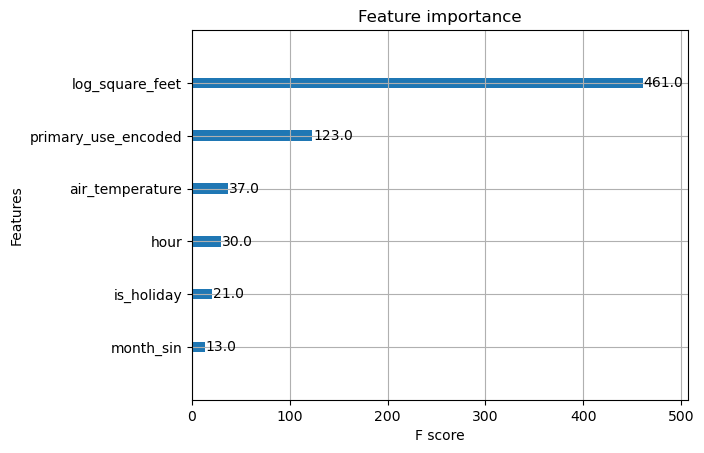

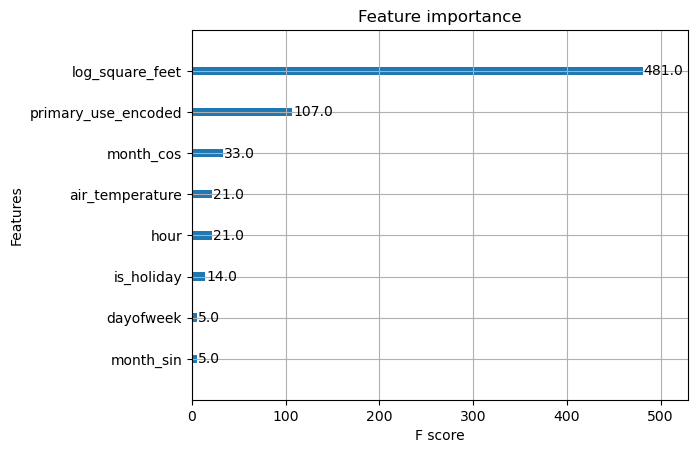

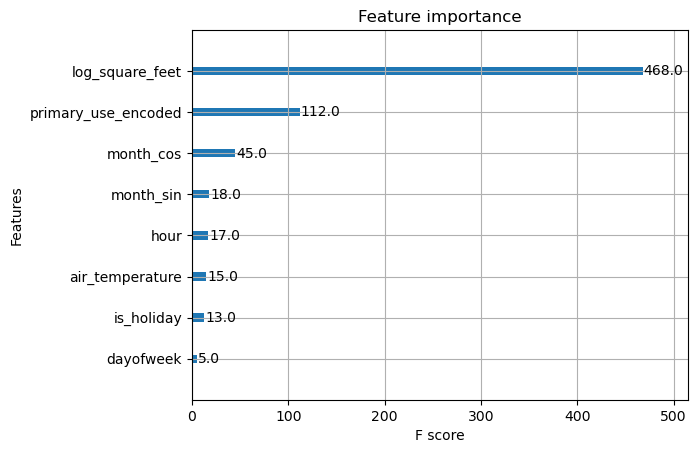

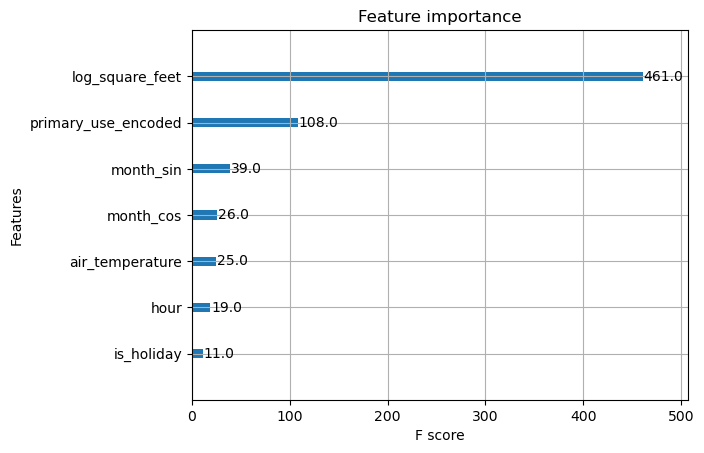

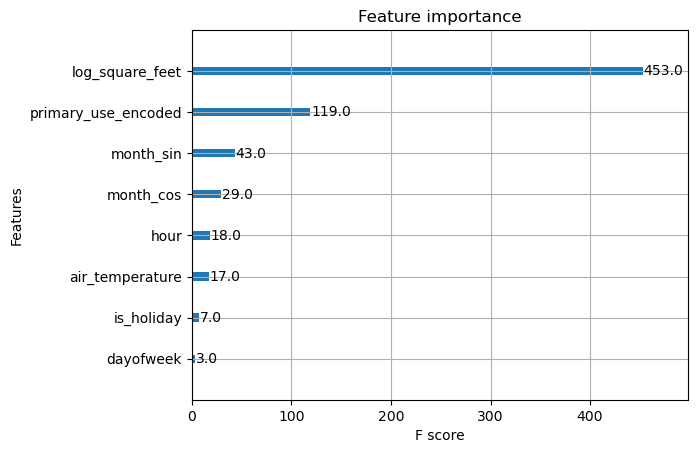

In [7]:
features = ['hour','air_temperature','month_sin','month_cos','log_square_feet', 'primary_use_encoded','is_holiday','dayofweek']
target = 'log_meter_reading'
models = []

df=df.sort_values(by='timestamp')
tscv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits

i = 1
for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i)
    print('Train: ',df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ',df_test['timestamp'].min(), df_test['timestamp'].max()) 
    i = i + 1 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = xgb.XGBRegressor(
    objective='reg:squarederror',  # Use 'reg:squarederror' for regression problems
    n_estimators=100,               # Number of boosting rounds (adjust as needed)
    learning_rate=0.1,              # Step size shrinkage to prevent overfitting
    max_depth=3                     # Maximum depth of each tree (adjust as needed)
    )



    XGB.fit(X_train,y_train)
    models.append(XGB)
    
    y_pred_train = XGB.predict(X_train)
    train_error_mse = mean_squared_error(y_train,y_pred_train)
    train_error_r2 = r2_score(y_train,y_pred_train)
    train_error_mae = mean_absolute_error(y_train,y_pred_train)

    print("MSE for train set is: ",train_error_mse)

    print("R2 for train set is: ",train_error_r2)

    print("MAE for train set is: ",train_error_mae)

    y_pred_test = XGB.predict(X_test)
    test_error_mse = mean_squared_error(y_test,y_pred_test)
    test_error_r2 = r2_score(y_test,y_pred_test)
    test_error_mae = mean_absolute_error(y_test,y_pred_test)

    

    print("MSE for test set is: ",test_error_mse)

    print("R2 for test set is: ",test_error_r2)

    print("MAE for test set is: ",test_error_mae)

    print("--------------------------------")

    MSE_train.append(train_error_mse)
    R2_train.append(train_error_r2)
    MAE_train.append(train_error_mae)

    MSE_test.append(test_error_mse)
    R2_test.append(test_error_r2)
    MAE_test.append(test_error_mae)

    xgb.plot_importance(XGB)



fold : 1
Train:  2016-01-01 08:00:00 2016-03-02 16:00:00
Test:  2016-03-02 16:00:00 2016-05-03 09:00:00


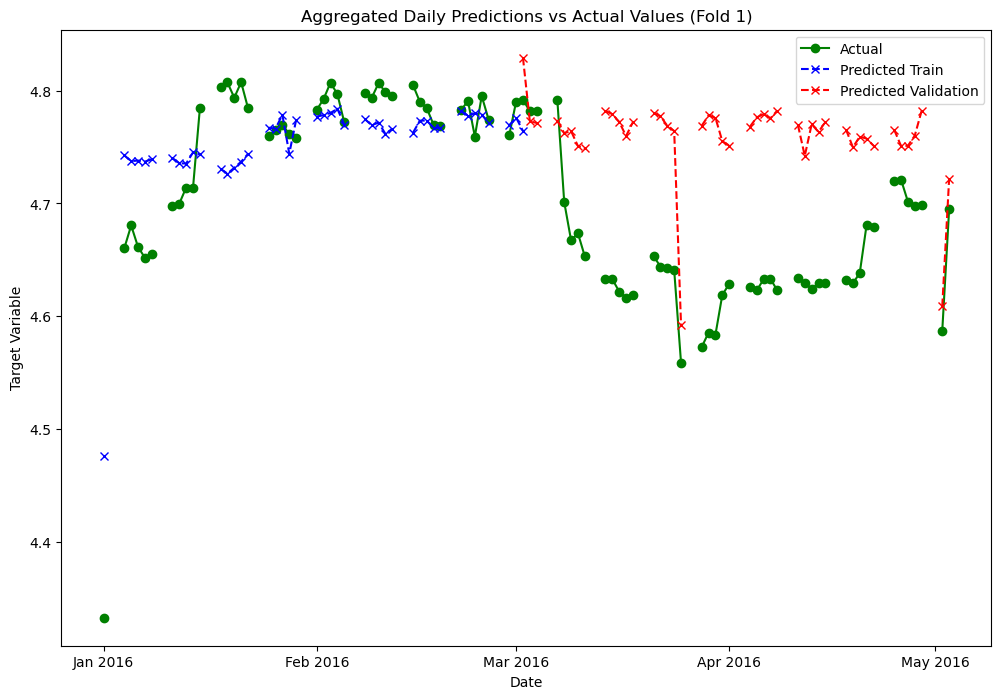

fold : 2
Train:  2016-01-01 08:00:00 2016-05-03 09:00:00
Test:  2016-05-03 09:00:00 2016-07-01 13:00:00


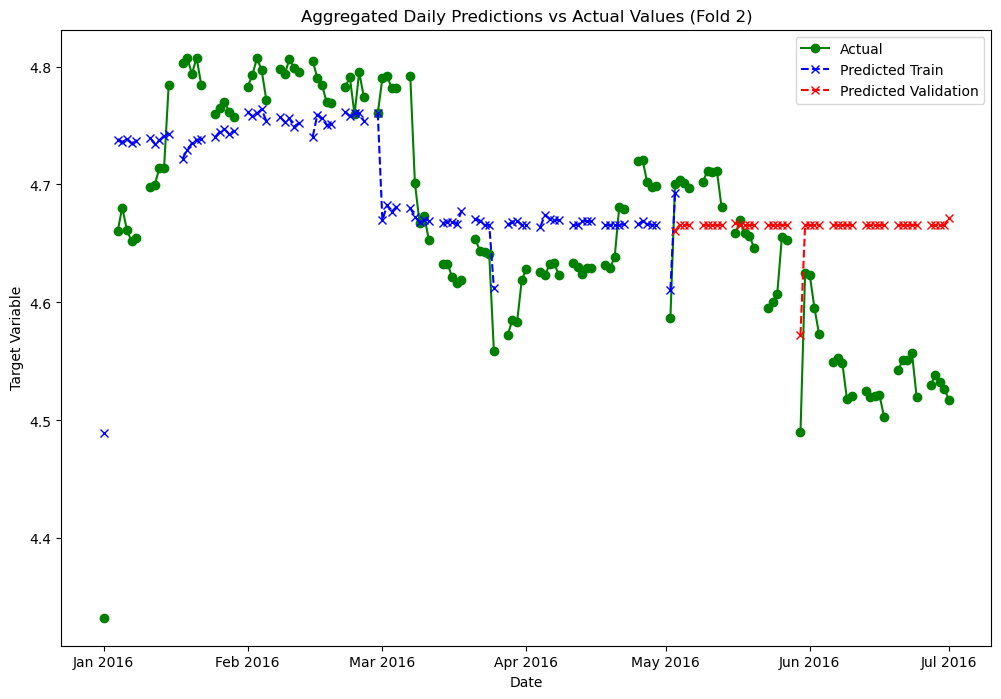

fold : 3
Train:  2016-01-01 08:00:00 2016-07-01 13:00:00
Test:  2016-07-01 13:00:00 2016-08-31 18:00:00


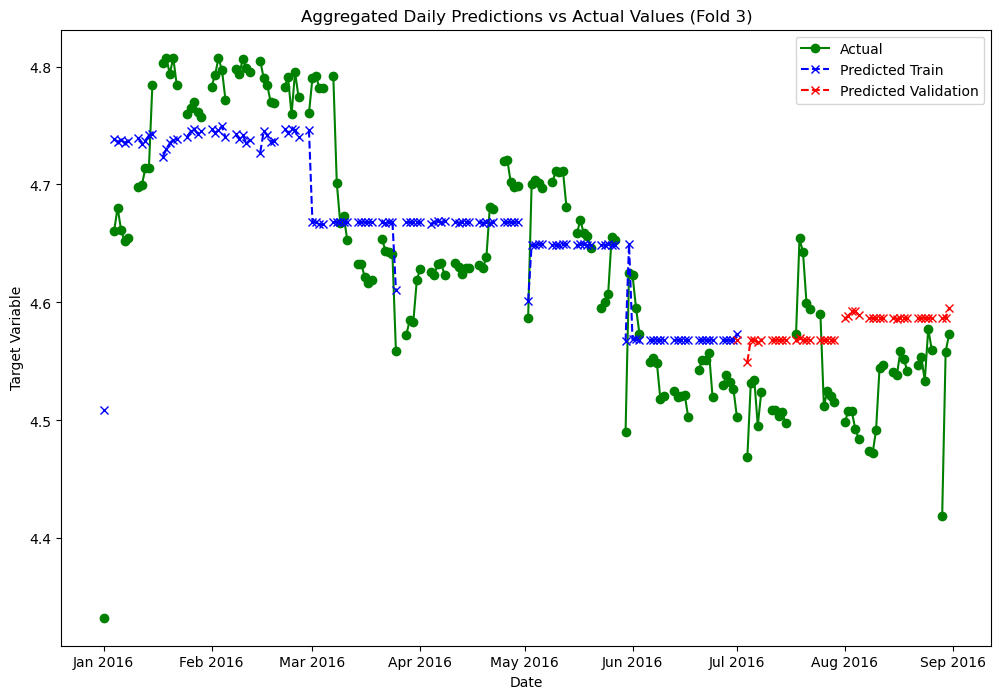

fold : 4
Train:  2016-01-01 08:00:00 2016-08-31 18:00:00
Test:  2016-08-31 18:00:00 2016-11-01 12:00:00


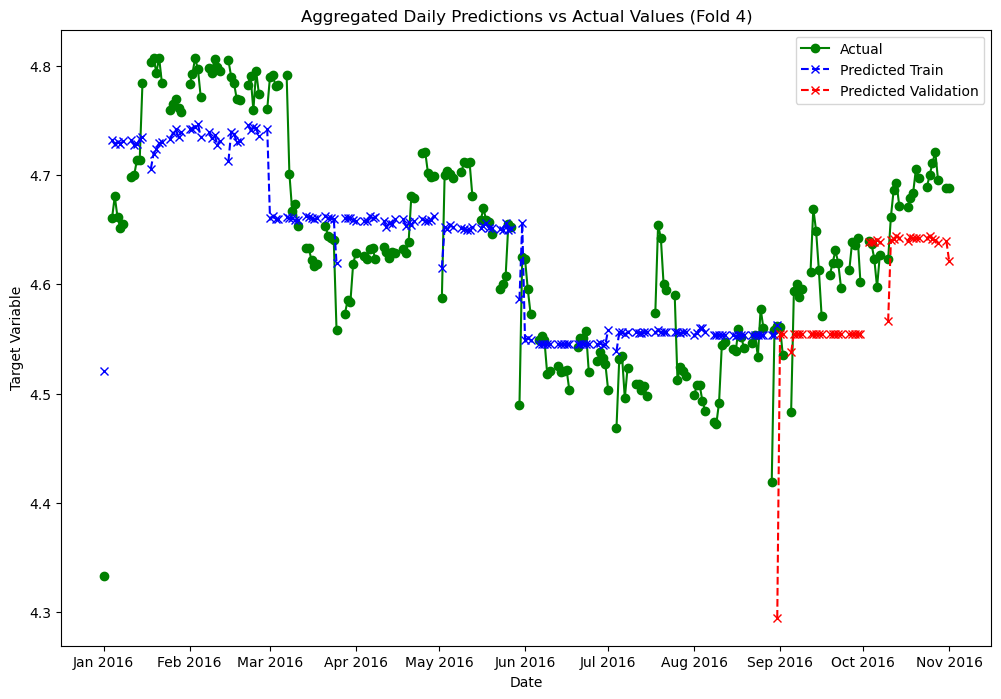

fold : 5
Train:  2016-01-01 08:00:00 2016-11-01 12:00:00
Test:  2016-11-01 12:00:00 2016-12-30 18:00:00


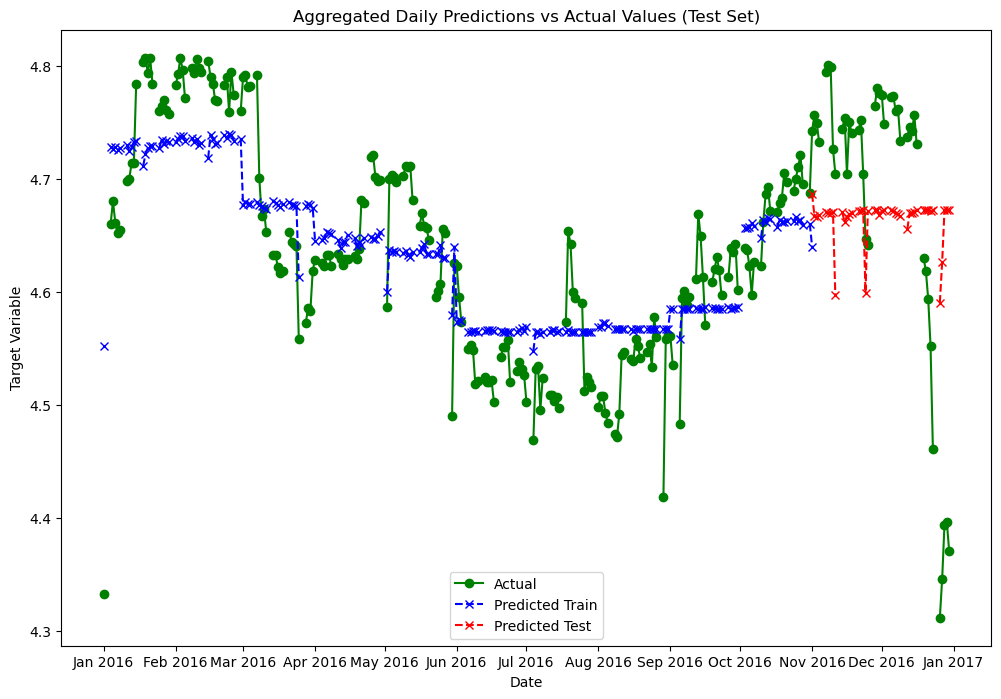

In [8]:
i = 0  # Start fold index from 1

for train_index, test_index in tscv.split(df):
    df_train, df_test = df.iloc[train_index], df.iloc[test_index]
    print('fold :', i+1)
    print('Train: ', df_train['timestamp'].min(), df_train['timestamp'].max()) 
    print('Test: ', df_test['timestamp'].min(), df_test['timestamp'].max()) 

    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target]
    y_test = df_test[target]

    XGB = models[i]
    i = i+1
    XGB.fit(X_train, y_train)
    
    y_pred_train = XGB.predict(X_train)
    y_pred_test = XGB.predict(X_test)

    # DataFrames to store aggregated values for the current fold
    aggregated_actual_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'actual': y_train}),
                                      pd.DataFrame({'timestamp': df_test['timestamp'], 'actual': y_test})])

    aggregated_predicted_df = pd.concat([pd.DataFrame({'timestamp': df_train['timestamp'], 'predicted_train': y_pred_train}),
                                         pd.DataFrame({'timestamp': df_test['timestamp'], 'predicted_test': y_pred_test})])

    # Group by timestamp and resample on a daily basis
    aggregated_actual_df.set_index('timestamp', inplace=True)
    aggregated_predicted_df.set_index('timestamp', inplace=True)

    aggregated_actual_daily = aggregated_actual_df.resample('D').mean()
    aggregated_predicted_daily = aggregated_predicted_df.resample('D').mean()

    # Plotting aggregated daily predictions for the current fold
    plt.figure(figsize=(12, 8))
    plt.plot(aggregated_actual_daily.index, aggregated_actual_daily['actual'], label='Actual', marker='o', color='green')
    plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_train'], label='Predicted Train', marker='x', linestyle='--', color='blue')

    if (i==5):
        plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_test'], label='Predicted Test', marker='x', linestyle='--', color='red')
        plt.title(f'Aggregated Daily Predictions vs Actual Values (Test Set)')
    else:
        plt.plot(aggregated_predicted_daily.index, aggregated_predicted_daily['predicted_test'], label='Predicted Validation', marker='x', linestyle='--', color='red')
        plt.title(f'Aggregated Daily Predictions vs Actual Values (Fold {i})')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    # Format x-axis ticks as months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())    

    plt.show()

    

In [10]:

# Test Set Errors:
print("MSE Train Error:", MSE_train[-1])
print("R2 Train:", R2_train[-1])
print("MAE Train Error:", MAE_train[-1])

print("MSE Test Error:", MSE_test[-1])
print("R2 Test Error:", R2_test[-1]) 
print("MAE Test Error:", MAE_test[-1])


MSE Train Error: 0.19942791288736933
R2 Train: 0.8772941456559067
MAE Train Error: 0.2987829421686818
MSE Test Error: 0.6071280902558609
R2 Test Error: 0.547619665244161
MAE Test Error: 0.40157798167096403


# Save the model for train&test set

In [15]:
utils.save_model(models[4],"XGB_v1")